# (MultiFiT) Portuguese Sentiment Classifier on Brazilian E-Commerce Public Dataset by Olist
- **Architecture 4 QRNN with 1550 hidden parameters by layer, SentencePiece tokenizer (15 000 tokens)**
- **Hyperparameters and training method from the MultiFiT paper (except the Label Smoothing for the loss)**

**Information**

According to this new article "[MultiFiT: Efficient Multi-lingual Language Model Fine-tuning](https://arxiv.org/abs/1909.04761)" (September 10, 2019), the QRNN architecture and the SentencePiece tokenizer give better results than AWD-LSTM and the spaCy tokenizer respectively. 

Therefore, they have been used in this notebook to **fine-tune a Portuguese Bidirectional Language Model** by Transfer Learning of a Portuguese Bidirectional Language Model (with the QRNN architecture and the SentencePiece tokenizer, too) trained on a Wikipedia corpus of 100 millions tokens ([lm3-portuguese.ipynb](https://github.com/piegu/language-models/blob/master/lm3-portuguese.ipynb)). 

This Portuguese Bidirectional Language Model has been **fine-tuned on "[Brazilian E-Commerce Public Reviews Dataset by Olist](https://www.kaggle.com/olistbr/brazilian-ecommerce/metadata)"** and **its encoder part has been transfered to a sentiment classifier which has been finally trained on this Olist corpus**.

This process **LM General --> LM fine-tuned --> Classifier fine-tuned** is called [ULMFiT](http://nlp.fast.ai/category/classification.html) but we trained our 3 models with the hyperparameters values of the [MultiFiT](https://arxiv.org/abs/1909.04761) method given at the end of the MultiFiT article.

**Hyperparameters values**

- Language Model
    - (batch size) bs = 50
    - (QRNN) 4 QRNN (default: 3) with 1550 hidden parameters each one (default: 1152)
    - (SentencePiece) vocab of 15000 tokens
    - (dropout) mult_drop = 1.0
    - (weight decay) wd = 0.1
    - (number of training epochs) 17 epochs
    - (learning rate) modified version of 1-cycle learning rate schedule (Smith, 2018) that uses cosine instead of linear annealing, cyclical momentum and discriminative finetuning
    - (loss) FlattenedLoss of CrossEntropyLoss
    

- Sentiment Classifier
    - (batch size) bs = 18
    - (SentencePiece) vocab of 15000 tokens
    - (dropout) mult_drop = 1.0 
    - (weight decay) wd = 0.1
    - (number of training epochs) 9 epochs
    - (learning rate) modified version of 1-cycle learning rate schedule (Smith, 2018) that uses cosine instead of linear annealing, cyclical momentum and discriminative finetuning
    - (loss) FlattenedLoss of weighted CrossEntropyLoss
    
**Note**: the MultiFiT values of mult_drop and weight decay are respectively 0.5 and 0.01 but as the Olist dataset after pre-processing is small, we need to increase regularization. Therefore, we did test and we finally chose mult_drop = 1.0 and wd = 0.1 both for fine-tuning the Bidirectional LM and the Sentiment Classifier. More, we trained the Bidirectional LM on 17 epochs and not 20 for the same reason (our models overfitted beacuse of the small size of teh dataset on 20 epochs). 

## Results

**We can conclude that this Bidirectional Portuguese LM model using the MultiFiT configuration is a good model to perform text classification but with only 46 millions of parameters, it is far from being a LM that can gan compete with [GPT-2](https://openai.com/blog/better-language-models/) or [BERT](https://arxiv.org/abs/1810.04805) in NLP tasks like text generation.**

- **About the data**: the dataset "Brazilian E-Commerce Public Dataset by Olist", even after pre-processing (deleting empty reviews, neutral ones, etc.), is unbalanced. Therefore, we used a weighted loss function (FlattenedLoss of weighted CrossEntropyLoss).
    - initial number of reviews: 100 000
    - number of reviews after pre-processing: 37 770
        - neg: 11270 (29.84%)
        - pos: 26500 (70.16%)


- **(fine-tuned) Language Model**   
    - forward : (accuracy) 34.74% | (perplexity) 27.42
    - backward: (global) 38.24% | (perplexity) 27.84
    

- **(fine-tuned) Sentiment Classifier**

    - **Accuracy**
        - forward : (global) **92.80%** | (neg) 95.10% | **(pos) 91.80%**
        - backward: (global) 91.08% | **(neg) 96.33%** | (pos) 88.80%
        - ensemble: (global) 92.30% | (neg) 95.80% | (pos) 90.77%

    - **f1 score**
        - forward: **0.9467**
        - backward: 0.9328
        - ensemble: 0.9426
    

(neg = negative reviews | pos = positive reviews)

### To be improved

- Author: [Pierre Guillou](https://www.linkedin.com/in/pierreguillou)
- Date: September 2019
- Post in medium: [link](https://medium.com/@pierre_guillou/nlp-fastai-portuguese-language-model-980c8ec75362)
- Ref: [Fastai v1](https://docs.fast.ai/) (Deep Learning library on PyTorch)

The lost function FlattenedLoss of LabelSmoothingCrossEntropy should be tested as it is used in the MultiFiT method (see the notebook [lm3-portuguese-classifier-TCU-jurisprudencia.ipynb](https://github.com/piegu/language-models/blob/master/lm3-portuguese-classifier-TCU-jurisprudencia.ipynb) to get the code).

## Initialisation

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai import *
from fastai.text import *
from fastai.callbacks import *

In [2]:
from sklearn.metrics import f1_score

@np_func
def f1(inp,targ): return f1_score(targ, np.argmax(inp, axis=-1))

In [3]:
# bs=48
# bs=24
bs=50

In [4]:
torch.cuda.set_device(0)

In [5]:

#from pathlib import Path
##  IF USING GOOGLE COLAB
#from google.colab import drive
#drive.mount('/content/gdrive', force_remount=True)




In [6]:
data_path = Path('../../data/')
prog_path = Path('/content/gdrive/My Drive/Colab Notebooks/nlp/multfit')

#### works well to check directory structure in google drive
data_path.ls()

[PosixPath('../../data/olist'),
 PosixPath('../../data/.ipynb_checkpoints'),
 PosixPath('../../data/lid.176.bin'),
 PosixPath('../../data/ptwiki')]

This will create a `{lang}wiki` folder, containing a `{lang}wiki` text file with the wikipedia contents. (For other languages, replace `{lang}` with the appropriate code from the [list of wikipedias](https://meta.wikimedia.org/wiki/List_of_Wikipedias).)

In [7]:
lang = 'pt'

In [8]:
name = f'{lang}wiki'
#path = data_path/name
path = data_path/name
path.mkdir(exist_ok=True, parents=True)

lm_fns3 = [f'{lang}_wt_sp15_multifit', f'{lang}_wt_vocab_sp15_multifit']
lm_fns3_bwd = [f'{lang}_wt_sp15_multifit_bwd', f'{lang}_wt_vocab_sp15_multifit_bwd']
lm_fns3

['pt_wt_sp15_multifit', 'pt_wt_vocab_sp15_multifit']

## Data

- [Brazilian E-Commerce Public Dataset by Olist](https://www.kaggle.com/olistbr/brazilian-ecommerce/metadata)
- File: olist_order_reviews_dataset.csv

In [9]:
name = 'olist'
path_data = data_path/name
path_data.ls()

[PosixPath('../../data/olist/olist_order_reviews_dataset.csv'),
 PosixPath('../../data/olist/olist_reviews_filtered_pt.csv'),
 PosixPath('../../data/olist/product_category_name_translation.csv'),
 PosixPath('../../data/olist/olist_geolocation_dataset.csv'),
 PosixPath('../../data/olist/olist_order_items_dataset.csv'),
 PosixPath('../../data/olist/olist_reviews_tobechecked_pt.csv'),
 PosixPath('../../data/olist/olist_customers_dataset.csv'),
 PosixPath('../../data/olist/olist_products_dataset.csv'),
 PosixPath('../../data/olist/olist_sellers_dataset.csv'),
 PosixPath('../../data/olist/olist_orders_dataset.csv'),
 PosixPath('../../data/olist/olist_order_payments_dataset.csv')]

### Run this code the first time

In [10]:
#import sys
#sys.path.append('/content/gdrive/My Drive/Colab Notebooks/nlp/multfit')
#sys.path


In [11]:
from  converter import *

In [12]:
# to solve display error of pandas dataframe
get_ipython().config.get('IPKernelApp', {})['parent_appname'] = ""

In [13]:
df = pd.read_csv(path_data/'olist_order_reviews_dataset.csv', encoding='utf-8')
print(len(df))
df.head()

100000


,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-10 00:00:00,2018-03-11 03:05:13
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN,NaN,2018-02-17 00:00:00,2018-02-18 14:36:24
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,NaN,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,NaN,Parabéns lojas lannister adorei comprar pela I...,2018-03-01 00:00:00,2018-03-02 10:26:53


In [14]:
# columns names
reviews = "review_comment_message"
idx = "review_id"
rating = "review_score"
label = "label"

# keep columns
df2 = df[[idx,reviews,rating]].copy()

In [15]:
# number of reviews
print(f'(orginal csv) number of all reviews: {len(df2)}')

# keep not null reviews
## delete nan reviews
empty_nan = (df2[reviews].isnull()).sum()
df2 = df2[df2[reviews].notnull()]
## delete empty reviews
list_idx_none = []
for idxs, row in df2.iterrows():
    if row[reviews].strip() == "":
        df2.drop(idxs, axis=0, inplace=True)
        list_idx_none.append(idxs)
empty_none = len(list_idx_none)
## print results
empty = empty_nan+empty_none
if empty != 0:
    print(f'{empty} empty reviews were deleted')
else:
    print('there is no empty review.')

# check that there is no twice the same review
# keep the first of unique review_id reviews
same = len(df2) - len(df2[idx].unique())
if same != 0:
    df2.drop_duplicates(subset=[idx], inplace=True)
    print(f'from the {same} identical reviews ids, only the first one has been kept.')
else:
    print('there is no identical review id.')

# categorify reviews in 2 classes neg, pos in the label column (rating != 3)
neutral = len(df2[df2[rating] == 3])
df2 = df2[df2[rating] != 3]
df2[label] = 'neg'
df2.loc[df2[rating] > 3, label] = 'pos'
print(f'{neutral} neutral reviews (rating = 3) were deleted')

## delete nan labels
empty_label_nan = (df2[label].isnull()).sum()
df2 = df2[df2[label].notnull()]
print(f'{empty_label_nan} reviews with nan label were deleted')



# number of reviews neg or pos
num_neg = len(df2[df2[label] == 'neg'])
num_pos = len(df2[df2[label] == 'pos'])
num_neg_pos = len(df2)
pc_neg = round((num_neg/num_neg_pos)*100,2)
pc_pos = round((num_pos/num_neg_pos)*100,2)
print(f'\nnumber of neg reviews (rating = 1 or 2): {num_neg} ({pc_neg}%)')
print(f'number of pos reviews (rating = 4 or 5): {num_pos} ({pc_pos}%)')
print(f'\n(final) number of all reviews neg and pos: {num_neg_pos}')  

# convert HTML caracters to normal letters
#df2[reviews] = df2[reviews].apply(convert)

df2.head(10)

(orginal csv) number of all reviews: 100000
58274 empty reviews were deleted
from the 322 identical reviews ids, only the first one has been kept.
3634 neutral reviews (rating = 3) were deleted
0 reviews with nan label were deleted

number of neg reviews (rating = 1 or 2): 11270 (29.84%)
number of pos reviews (rating = 4 or 5): 26500 (70.16%)

(final) number of all reviews neg and pos: 37770


,review_id,review_comment_message,review_score,label
3,e64fb393e7b32834bb789ff8bb30750e,Recebi bem antes do prazo estipulado.,5,pos
4,f7c4243c7fe1938f181bec41a392bdeb,Parabéns lojas lannister adorei comprar pela I...,5,pos
9,8670d52e15e00043ae7de4c01cc2fe06,aparelho eficiente. no site a marca do aparelh...,4,pos
12,4b49719c8a200003f700d3d986ea1a19,"Mas um pouco ,travando...pelo valor ta Boa.\r\n",4,pos
15,3948b09f7c818e2d86c9a546758b2335,"Vendedor confiável, produto ok e entrega antes...",5,pos
16,9314d6f9799f5bfba510cc7bcd468c01,"GOSTARIA DE SABER O QUE HOUVE, SEMPRE RECEBI E...",2,neg
19,373cbeecea8286a2b66c97b1b157ec46,Péssimo,1,neg
22,d21bbc789670eab777d27372ab9094cc,Loja nota 10,5,pos
24,0e0190b9db53b689b285d3f3916f8441,obrigado pela atençao amim dispensada,5,pos
27,fe3db7c069d694bab50cc43463f91608,A compra foi realizada facilmente.\r\nA entreg...,5,pos


In [16]:
df2.review_comment_message= df2.review_comment_message.str.rstrip('\n\t\r')

In [28]:
df2= df2.dropna(how='any',axis=0) 

In [29]:
df2.isnull().sum() , len(df2)

(review_id                 0
 review_comment_message    0
 review_score              0
 label                     0
 dtype: int64, 37770)

In [30]:
df2.shape

(37770, 4)

#### Delete the non Portuguese reviews

**FastText**

- library source: https://github.com/facebookresearch/fastText/tree/master/python
- Blog post about using fasttext for language detection: https://amitness.com/2019/07/identify-text-language-python/
- "New release of python module" (june 2019): https://fasttext.cc/blog/2019/06/25/blog-post.html

In [31]:
import fasttext
#import urllib.request

In [32]:
# Download the file from url and save it locally under file_name
# source: https://fasttext.cc/docs/en/language-identification.html

#path_ft = Path.cwd() # /home/jupyter/tutorials/fastai/course-nlp
#url = 'https://dl.fbaipublicfiles.com/fasttext/supervised-models/lid.176.bin'
file_name = 'lid.176.bin'
#url_file = data_path/file_name
#urllib.request.urlretrieve(url, url_file)

In [33]:
data_path.ls()

[PosixPath('../../data/olist'),
 PosixPath('../../data/.ipynb_checkpoints'),
 PosixPath('../../data/lid.176.bin'),
 PosixPath('../../data/ptwiki')]

In [34]:
# get the model trained on 176 languages
model = fasttext.load_model('../../data/lid.176.bin')

In [35]:
# test
#sentences = ['Eu me chamo Roberto.']
sentences = [ 'אני אוהב אותך']

predictions = model.predict(sentences)
print(predictions[0][0][0].replace('__label__','') == 'pt')
print(predictions)

False
([['__label__he']], array([[0.999974]]))


In [36]:
%%time
list_idx = []
for idx, row in df2.iterrows():
    try:
        string = str(row[reviews]).replace('\r',' ').replace('\n','').replace('<br />', ' ').lower()
        predictions = model.predict(string)
        language = predictions[0][0].replace('__label__','')
    except:
        language = "error"
    if not (language == 'pt'):
        list_idx.append(idx)
        
print(f'number of non-Portuguese reviews: {len(list_idx)}')

number of non-Portuguese reviews: 2157
CPU times: user 3.92 s, sys: 12 ms, total: 3.93 s
Wall time: 3.93 s


In [37]:
df2[reviews][list_idx][:10]

19                      Péssimo
55                          boa
67     Recomendo o vendedor... 
90                Super rápido.
108                OK RECOMENDO
142                       OTIMA
160                          OK
204             nada a declarar
228                   Recomendo
231                decepcionado
Name: review_comment_message, dtype: object

In [38]:
df2[reviews][list_idx].to_csv (path_data/'olist_reviews_tobechecked_pt.csv', index = None, header=True)

After reading the 2 157 reviews labeled non Portuguese by fastText, we discovered that the majority was written in Portuguese. Therefore, we decided to keep all of them.

In [39]:
# df2.drop(list_idx, axis=0, inplace=True)
df_trn_val = df2.copy()

In [40]:
df_trn_val.isnull().sum()

review_id                 0
review_comment_message    0
review_score              0
label                     0
dtype: int64

In [41]:
df_trn_val.shape

(37770, 4)

#### Save filtered reviews dataset

number of neg reviews (rating = 1 or 2): 11270 (29.84%)
number of pos reviews (rating = 4 or 5): 26500 (70.16%)
number of all reviews: 37770


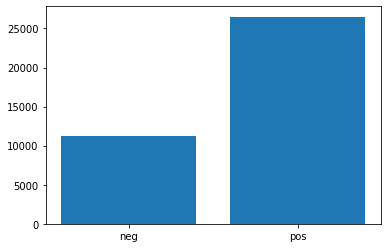

In [42]:
# number of reviews neg or pos
num_neg = len(df_trn_val[df_trn_val[label] == 'neg'])
num_pos = len(df_trn_val[df_trn_val[label] == 'pos'])
num_neg_pos = len(df_trn_val)
pc_neg = round((num_neg/num_neg_pos)*100,2)
pc_pos = round((num_pos/num_neg_pos)*100,2)
print(f'number of neg reviews (rating = 1 or 2): {num_neg} ({pc_neg}%)')
print(f'number of pos reviews (rating = 4 or 5): {num_pos} ({pc_pos}%)')
print(f'number of all reviews: {num_neg_pos}') 

# plot histogram
x= [1,2]
keys = list(df_trn_val[label].value_counts().keys())
values = list(df_trn_val[label].value_counts().array)
plt.bar(x, values[::-1]) 
plt.xticks(x, keys[::-1])
# print(df_trn_val['label'].value_counts())
plt.show()

In [43]:
df_trn_val.isnull().sum()

review_id                 0
review_comment_message    0
review_score              0
label                     0
dtype: int64

In [44]:
df_trn_val.to_csv (path_data/'olist_reviews_filtered_pt.csv', index = None, header=True, encoding='utf-8')

In [45]:
df_trn_val.shape

(37770, 4)

In [46]:
df_trn_val.iloc[10760]

review_id                                  50873387202cf407932d93a264b36271
review_comment_message    Estou aguardando a resposta de quando vão entr...
review_score                                                              1
label                                                                   neg
Name: 27959, dtype: object

### Get the csv of pre-processed data 

In [17]:
df2_trn_val = pd.read_csv(path_data/'olist_reviews_filtered_pt.csv', encoding='utf-8')


In [18]:
df2_trn_val.shape

(37770, 4)

In [19]:
df2_trn_val.isnull().sum()

review_id                 0
review_comment_message    0
review_score              0
label                     0
dtype: int64

## Fine-tuning "forward LM"

### Databunch

In [20]:
data_path, path_data

(PosixPath('../../data'), PosixPath('../../data/olist'))

In [21]:
dest = data_path/'ptwiki'
(dest/'tmp').ls()

[PosixPath('../../data/ptwiki/tmp/spm.vocab'),
 PosixPath('../../data/ptwiki/tmp/spm.model')]

In [22]:
%%time
data_lm = (TextList.from_df(df2_trn_val, path, cols=reviews, 
                            processor=[OpenFileProcessor(), SPProcessor(max_vocab_sz=15000)])
    .split_by_rand_pct(0.1, seed=42)
    .label_for_lm()           
    .databunch(bs=bs, num_workers=1))

CPU times: user 5.83 s, sys: 124 ms, total: 5.95 s
Wall time: 4.96 s


In [23]:
data_lm.save(f'{path}/{lang}_databunch_lm_aws_sp15_multifit')

In [24]:
path

PosixPath('../../data/ptwiki')

### Training

In [25]:
data_lm = load_data(path, f'{lang}_databunch_lm_aws_sp15_multifit', bs=bs)

In [26]:
config = awd_lstm_lm_config.copy()
config['qrnn'] = True
config['n_hid'] = 1550 #default 1152
config['n_layers'] = 4 #default 3

In [27]:
%%time
perplexity = Perplexity()
learn_lm = language_model_learner(data_lm, AWD_LSTM, config=config, pretrained_fnames=lm_fns3, drop_mult=1., 
                                  metrics=[error_rate, accuracy, perplexity]).to_fp16()

CPU times: user 2.65 s, sys: 864 ms, total: 3.52 s
Wall time: 37.8 s


In [28]:
learn_lm.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


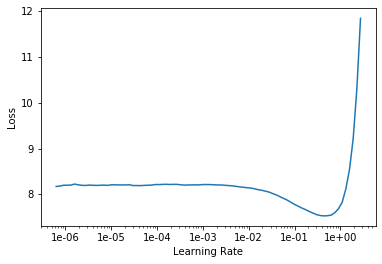

In [29]:
learn_lm.recorder.plot()

In [30]:
lr = 2e-2
lr *= bs/48

wd = 0.1

In [61]:
learn_lm.fit_one_cycle(2, lr*10, wd=wd, moms=(0.8,0.7))

epoch,train_loss,valid_loss,error_rate,accuracy,perplexity,time
0,18.459362,11.222668,0.922902,0.077098,74807.070312,00:10
1,7.012515,5.774346,0.897459,0.102541,321.934082,00:10


In [62]:
learn_lm.save(f'{lang}fine_tuned1_sp15_multifit')
learn_lm.save_encoder(f'{lang}fine_tuned1_enc_sp15_multifit')

epoch,train_loss,valid_loss,error_rate,accuracy,perplexity,time
0,4.761449,4.171163,0.735534,0.264466,64.790733,00:14
1,4.011419,3.703171,0.697609,0.302391,40.575748,00:14


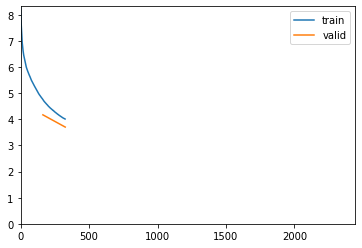

In [ ]:
learn_lm.unfreeze()
learn_lm.fit_one_cycle(15, lr, wd=wd, moms=(0.8,0.7), callbacks=[ShowGraph(learn_lm)])

In [ ]:
learn_lm.save(f'{lang}fine_tuned2_sp15_multifit')
learn_lm.save_encoder(f'{lang}fine_tuned2_enc_sp15_multifit')

Save best LM learner and its encoder

In [ ]:
learn_lm.save(f'{lang}fine_tuned_sp15_multifit')
learn_lm.save_encoder(f'{lang}fine_tuned_enc_sp15_multifit')

In [ ]:
learn_lm.model

## Fine-tuning "backward LM"

### Databunch

In [56]:
df_trn_val.shape

(37770, 4)

In [57]:
%%time
data_lm = (TextList.from_df(df2_trn_val, path, cols=reviews, 
                            processor=SPProcessor.load(dest))
    .split_by_rand_pct(0.1, seed=42)
    .label_for_lm()           
    .databunch(bs=bs, num_workers=1, backwards=True))

CPU times: user 1.5 s, sys: 268 ms, total: 1.77 s
Wall time: 2.61 s


In [58]:
data_lm.save(f'{path}/{lang}_databunch_lm_aws_sp15_multifit_bwd')

### Training

In [59]:
%%time
data_lm = load_data(path, f'{lang}_databunch_lm_aws_sp15_multifit_bwd', bs=bs, backwards=True)

CPU times: user 220 ms, sys: 16 ms, total: 236 ms
Wall time: 236 ms


In [60]:
config = awd_lstm_lm_config.copy()
config['qrnn'] = True
config['n_hid'] = 1550 #default 1152
config['n_layers'] = 4 #default 3

In [61]:
%%time
perplexity = Perplexity()
learn_lm = language_model_learner(data_lm, AWD_LSTM, config=config, pretrained_fnames=lm_fns3_bwd, drop_mult=1., 
                                  metrics=[error_rate, accuracy, perplexity]).to_fp16()

CPU times: user 532 ms, sys: 128 ms, total: 660 ms
Wall time: 509 ms


In [62]:
learn_lm.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


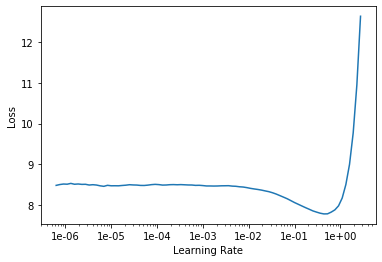

In [63]:
learn_lm.recorder.plot()

In [64]:
lr = 2e-2
lr *= bs/48

wd = 0.1

In [65]:
learn_lm.fit_one_cycle(2, lr*10, wd=wd, moms=(0.8,0.7))

epoch,train_loss,valid_loss,error_rate,accuracy,perplexity,time
0,22.441380,11.362500,0.951624,0.048376,86034.117188,00:10
1,8.904193,6.193478,0.911368,0.088632,489.546082,00:10


In [66]:
learn_lm.save(f'{lang}fine_tuned1_sp15_multifit_bwd')
learn_lm.save_encoder(f'{lang}fine_tuned1_enc_sp15_multifit_bwd')

epoch,train_loss,valid_loss,error_rate,accuracy,perplexity,time
0,5.673250,5.516432,0.863790,0.136211,248.745865,00:14
1,5.053987,4.806574,0.779428,0.220571,122.311966,00:14
2,4.438440,4.208589,0.712647,0.287353,67.261574,00:14
3,4.067228,3.920103,0.686346,0.313654,50.405663,00:14
4,3.905184,3.816694,0.675248,0.324752,45.453690,00:14
5,3.780110,3.727648,0.668571,0.331429,41.581215,00:14
6,3.696398,3.670497,0.662361,0.337639,39.271446,00:14
7,3.640896,3.623012,0.655624,0.344376,37.450199,00:14
8,3.549453,3.584831,0.651850,0.348150,36.047283,00:14
9,3.459952,3.542130,0.645007,0.354992,34.540413,00:14


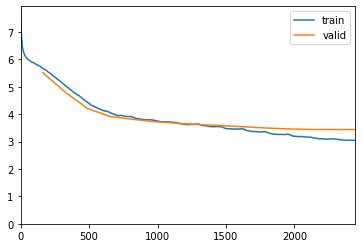

In [67]:
learn_lm.unfreeze()
learn_lm.fit_one_cycle(15, lr, wd=wd, moms=(0.8,0.7), callbacks=[ShowGraph(learn_lm)])

In [68]:
learn_lm.save(f'{lang}fine_tuned2_sp15_multifit_bwd')
learn_lm.save_encoder(f'{lang}fine_tuned2_enc_sp15_multifit_bwd')

Save best LM learner and its encoder

In [69]:
learn_lm.save(f'{lang}fine_tuned_sp15_multifit_bwd')
learn_lm.save_encoder(f'{lang}fine_tuned_enc_sp15_multifit_bwd')

## Fine-tuning "forward Classifier"

In [70]:
import warnings
warnings.filterwarnings('ignore')  # "error", "ignore", "always", "default", "module" or "on

In [71]:
bs = 18

### Databunch

In [72]:
%%time
data_lm = load_data(path, f'{lang}_databunch_lm_aws_sp15_multifit', bs=bs)

CPU times: user 204 ms, sys: 8 ms, total: 212 ms
Wall time: 207 ms


In [73]:
#keep reviews with a label not nan
#df2_trn_val = df_trn_val[df_trn_val[label].notnull()].copy()
#print(len(df2_trn_val))
#df2_trn_val.head()

In [74]:
%%time
data_clas = (TextList.from_df(df2_trn_val, path, vocab=data_lm.vocab, cols=reviews, 
                              processor=SPProcessor.load(dest))
    .split_by_rand_pct(0.1, seed=42)
    .label_from_df(cols=label)
    .databunch(bs=bs, num_workers=1))

CPU times: user 2.26 s, sys: 268 ms, total: 2.52 s
Wall time: 3.6 s


In [75]:
%%time
data_clas.save(f'{lang}_textlist_class_sp15_multifit')

CPU times: user 668 ms, sys: 36 ms, total: 704 ms
Wall time: 702 ms


### Get weights to penalize loss function of the majority class

In [76]:
#%%time
#data_clas = load_data(path, f'{lang}_textlist_class_sp15_multifit', bs=bs, num_workers=1)

In [77]:
num_trn = len(data_clas.train_ds.x)
num_val = len(data_clas.valid_ds.x)
num_trn, num_val, num_trn+num_val

(33993, 3777, 37770)

In [78]:
trn_LabelCounts = np.unique(data_clas.train_ds.y.items, return_counts=True)[1]
val_LabelCounts = np.unique(data_clas.valid_ds.y.items, return_counts=True)[1]
trn_LabelCounts, val_LabelCounts

(array([10126, 23867]), array([1144, 2633]))

In [79]:
trn_weights = [1 - count/num_trn for count in trn_LabelCounts]
val_weights = [1 - count/num_val for count in val_LabelCounts]
trn_weights, val_weights

([0.7021151413526314, 0.2978848586473686],
 [0.6971141117288854, 0.3028858882711146])

### Training (Loss = FlattenedLoss of weighted CrossEntropyLoss)

In [80]:
%%time
data_clas = load_data(path, f'{lang}_textlist_class_sp15_multifit', bs=bs, num_workers=1)

CPU times: user 996 ms, sys: 20 ms, total: 1.02 s
Wall time: 1 s


In [81]:
config = awd_lstm_clas_config.copy()
config['qrnn'] = True
config['n_hid'] = 1550 #default 1152
config['n_layers'] = 4 #default 3

In [82]:
learn_c = text_classifier_learner(data_clas, AWD_LSTM, config=config, pretrained = False,drop_mult=1.0, 
                                  metrics=[accuracy,f1]).to_fp16()


In [83]:
learn_c.load_encoder(f'{lang}fine_tuned_enc_sp15_multifit');

In [84]:
learn_c.model


SequentialRNN(
  (0): MultiBatchEncoder(
    (module): AWD_LSTM(
      (encoder): Embedding(6328, 400, padding_idx=1)
      (encoder_dp): EmbeddingDropout(
        (emb): Embedding(6328, 400, padding_idx=1)
      )
      (rnns): ModuleList(
        (0): QRNN(
          (layers): ModuleList(
            (0): QRNNLayer(
              (linear): WeightDropout(
                (module): Linear(in_features=800, out_features=4650, bias=True)
              )
            )
          )
        )
        (1): QRNN(
          (layers): ModuleList(
            (0): QRNNLayer(
              (linear): WeightDropout(
                (module): Linear(in_features=1550, out_features=4650, bias=True)
              )
            )
          )
        )
        (2): QRNN(
          (layers): ModuleList(
            (0): QRNNLayer(
              (linear): WeightDropout(
                (module): Linear(in_features=1550, out_features=4650, bias=True)
              )
            )
          )
        )
       

#### Change loss function

In [85]:
learn_c.loss_func

FlattenedLoss of CrossEntropyLoss()

In [86]:
loss_weights = torch.FloatTensor(trn_weights).cuda()
learn_c.loss_func = partial(F.cross_entropy, weight=loss_weights)

In [87]:
learn_c.loss_func

functools.partial(<function cross_entropy at 0x7fc0dc6389e0>, weight=tensor([0.7021, 0.2979], device='cuda:0'))

#### Training

In [88]:
learn_c.freeze()

In [89]:
learn_c.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


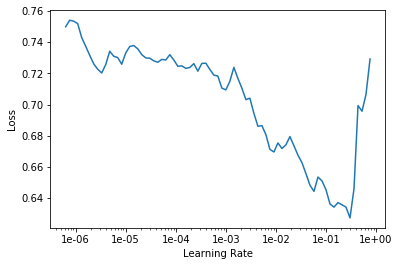

In [90]:
learn_c.recorder.plot()

In [91]:
lr = 3e-3
lr *= bs/48

wd = 0.1

In [92]:
learn_c.fit_one_cycle(2, lr, wd=wd, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,f1,time
0,0.355933,0.221455,0.906804,0.887064,00:20
1,0.345825,0.232262,0.918454,0.910903,00:20


In [93]:
learn_c.save(f'{lang}clas1_sp15_multifit')

In [94]:
learn_c.load(f'{lang}clas1_sp15_multifit');
learn_c.fit_one_cycle(2, lr, wd=wd, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,f1,time
0,0.346408,0.241400,0.887212,0.842482,00:20
1,0.338357,0.223744,0.915541,0.902733,00:20


In [95]:
learn_c.save(f'{lang}clas2_sp15_multifit')

In [96]:
learn_c.load(f'{lang}clas2_sp15_multifit');
learn_c.freeze_to(-2)
learn_c.fit_one_cycle(2, slice(lr/(2.6**4),lr), wd=wd, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,f1,time
0,0.347973,0.211975,0.910511,0.892303,00:24
1,0.370678,0.220552,0.929838,0.926402,00:24


In [97]:
learn_c.save(f'{lang}clas3_sp15_multifit')

In [98]:
learn_c.load(f'{lang}clas3_sp15_multifit');
learn_c.freeze_to(-3)
learn_c.fit_one_cycle(2, slice(lr/2/(2.6**4),lr/2), wd=wd, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,f1,time
0,0.297581,0.205480,0.916336,0.904016,00:28
1,0.297761,0.204095,0.911570,0.894392,00:28


In [99]:
learn_c.save(f'{lang}clas4_sp15_multifit')

In [100]:
learn_c.load(f'{lang}clas4_sp15_multifit');
learn_c.unfreeze()
learn_c.fit_one_cycle(1, slice(lr/10/(2.6**4),lr/10), wd=wd, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,f1,time
0,0.313511,0.200985,0.915541,0.899841,00:44


In [101]:
learn_c.save(f'{lang}clas5_sp15_multifit')

In [102]:
learn_c.load(f'{lang}clas5_sp15_multifit')
learn_c.save(f'{lang}clas_sp15_multifit')

In [103]:
#### LOADING PRE TRAINED FORWARD CLASSIFICATION MODEL

# RUN FIRST Get weights to penalize loss function of the majority class

data_clas = load_data(path, f'{lang}_textlist_class_sp15_multifit', bs=bs, num_workers=1)

config = awd_lstm_clas_config.copy()
config['qrnn'] = True
config['n_hid'] = 1550 #default 1152
config['n_layers'] = 4 #default 3

learn_c = text_classifier_learner(data_clas, AWD_LSTM, config=config, pretrained=False, drop_mult=1.0, 
                                  metrics=[accuracy,f1]).to_fp16()



learn_c.load_encoder(f'{lang}fine_tuned_enc_sp15_multifit');

learn_c.load(f'{lang}clas_sp15_multifit');
learn_c.to_fp32().export(f'{lang}_classifier_sp15_multifit')

### Confusion matrix

In [104]:
%%time
data_clas = load_data(path, f'{lang}_textlist_class_sp15_multifit', bs=bs, num_workers=1)

config = awd_lstm_clas_config.copy()
config['qrnn'] = True
config['n_hid'] = 1550 #default 1152
config['n_layers'] = 4 #default 3

learn_c = text_classifier_learner(data_clas, AWD_LSTM, config=config, pretrained=False, drop_mult=1.0, 
                                  metrics=[accuracy,f1])
learn_c.load_encoder(f'{lang}fine_tuned_enc_sp15_multifit');

learn_c.load(f'{lang}clas_sp15_multifit');

# put weight on cpu
loss_weights = torch.FloatTensor(trn_weights).cpu()
learn_c.loss_func = partial(F.cross_entropy, weight=loss_weights)

CPU times: user 1.42 s, sys: 104 ms, total: 1.52 s
Wall time: 1.5 s


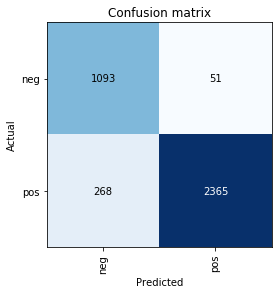

In [105]:
preds,y,losses = learn_c.get_preds(with_loss=True)
predictions = np.argmax(preds, axis = 1)

interp = ClassificationInterpretation(learn_c, preds, y, losses)
interp.plot_confusion_matrix()

In [106]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(np.array(y), np.array(predictions))
print(cm)

## acc
print(f'accuracy global: {(cm[0,0]+cm[1,1])/(cm[0,0]+cm[0,1]+cm[1,0]+cm[1,1])}')

# acc neg, acc pos
print(f'accuracy on negative reviews: {cm[0,0]/(cm[0,0]+cm[0,1])*100}') 
print(f'accuracy on positive reviews: {cm[1,1]/(cm[1,0]+cm[1,1])*100}')

[[1093   51]
 [ 268 2365]]
accuracy global: 0.9155414350013238
accuracy on negative reviews: 95.54195804195804
accuracy on positive reviews: 89.82149639194836


In [107]:
learn_c.show_results()

text,target,prediction
"▁xxbos ▁o ▁xxmaj ▁produto ▁xxmaj ▁relógio ▁xxmaj ▁invi cta ▁xxmaj ▁pro ▁xxmaj ▁di ver ▁ - ▁2 19 5 4 , ▁xxup ▁veio ▁xxup ▁trocado ▁xxup ▁pelo ▁xxup ▁invi cta ▁xxup ▁pro ▁xxup ▁di ver ▁2 400 1 , ▁xxup ▁tudo ▁xxup ▁bem ▁xxup ▁produto ▁xxup ▁similar , ▁xxup ▁mas ▁o ▁xxup ▁produto ▁xxmaj ▁relógio ▁xxmaj ▁invi cta ▁xxmaj ▁ s pe ci al t y ▁xxup ▁2 14 39",neg,neg
"▁xxbos ▁xxmaj ▁pedido : ▁02-66 2 11 99 05 ▁xxmaj ▁alça ▁xxmaj ▁dupla ▁xxmaj ▁x - do u b le ▁xxmaj ▁couro ▁xxmaj ▁ le gi timo ▁xxmaj ▁camera s ▁xxmaj ▁d s l r ▁xxmaj ▁do u b le ▁xxmaj ▁ s t ra p ▁xxup ▁informo ▁xxup ▁que ▁o ▁xxup ▁produto ▁xxup ▁não ▁xxup ▁foi ▁xxup ▁entregue , ▁xxup ▁porém ▁xxup ▁no ▁xxup ▁site ▁xxup ▁está ▁xxup ▁sendo",neg,neg
"▁xxbos ▁xxup ▁ola ! ▁xxup ▁bom ▁xxup ▁dia ▁ . ▁o ▁xxup ▁produto ▁xxup ▁foi ▁xxup ▁cobrado ▁xxup ▁um ▁xxup ▁alto ▁xxup ▁frete ▁e ▁xxup ▁não ▁xxup ▁foi ▁xxup ▁entregue ▁xxup ▁no ▁xxup ▁meu ▁xxup ▁endereço , tive ▁xxup ▁que ▁xxup ▁retirar ▁xxup ▁na ▁xxup ▁agência ▁xxup ▁do ▁xxup ▁correios ▁xxup ▁ , pois ▁xxup ▁vcs ▁xxup ▁deveria ▁xxup ▁devolver ▁o ▁xxup ▁valor ▁xxup ▁do ▁xxup ▁frete ▁xxup ▁ ,",pos,neg
"▁xxbos ▁xxup ▁desde ▁o ▁xxup ▁dia ▁23 - 04 - 18 ▁xxup ▁era ▁xxup ▁pra ▁xxup ▁ser ▁xxup ▁entregue ▁xxup ▁eles ▁xxup ▁nao ▁xxup ▁com pr ira o ▁a ▁xxup ▁entraga r ▁xxup ▁do ▁xxup ▁produto ▁xxup ▁to ▁xxup ▁mt ▁xxup ▁triste ▁xxup ▁com ▁xxup ▁essa ▁xxup ▁empresa ▁25 - 04 - 18 ▁xxup ▁as ▁17 , 20 ▁xxup ▁nao ▁xxup ▁chegou ▁xxup ▁aguardo ▁xxup ▁contato ▁xxup ▁te l ▁",neg,neg
"▁xxbos ▁xxup ▁foi ▁xxup ▁feito ▁o ▁xxup ▁pedido ▁xxup ▁de ▁2 ▁xxup ▁( u nd ) ▁xxup ▁do ▁xxup ▁produto , ▁xxup ▁chegou ▁xxup ▁apenas ▁xxup ▁1 ( u nd ), ▁e ▁xxup ▁mesmo ▁xxup ▁assim ▁xxup ▁fora ▁xxup ▁do ▁xxup ▁prazo ▁xxup ▁de ▁xxup ▁entrega , ▁xxup ▁já ▁xxup ▁enviei ▁xxup ▁vários ▁xxup ▁emails ▁xxup ▁para ▁xxup ▁resolve ▁o ▁xxup ▁problema ▁e ▁xxup ▁ate ▁xxup ▁agora ▁xxup ▁não ▁xxup",neg,neg


### Predictions some random sentences

In [108]:
import matplotlib.cm as cm

In [109]:
# Get the prediction neg/pos
review = 'Eu não gosto deste produto'
pred = learn_c.predict(review)
print(pred[0], pred[2])

neg tensor([0.8884, 0.1116])


In [110]:
# The darker the word-shading in the below example, the more it contributes to the classification. 
txt_ci = TextClassificationInterpretation.from_learner(learn_c)
test_text = "Eu não gosto deste produto"
txt_ci.show_intrinsic_attention(test_text,cmap=cm.Purples)

In [111]:
txt_ci.intrinsic_attention(test_text)[1]

tensor([0.1521, 0.1389, 0.3309, 0.5452, 0.9181, 1.0000, 0.3585],
       device='cuda:0')

In [112]:
# tabulation showing the first k texts in top_losses along with their prediction, actual,loss, and probability of actual class.
# max_len is the maximum number of tokens displayed. If max_len=None, it will display all tokens.
txt_ci.show_top_losses(5)

Text,Prediction,Actual,Loss,Probability
▁xxbos ▁xxmaj ▁entrega ▁super ▁rápida ... ▁xxmaj ▁produto ▁com ▁ótima ▁qualidade ... ▁xxmaj ▁super ▁recomendo ...,pos,neg,5.41,0.00
▁xxbos ▁xxmaj ▁ótimo ▁site ▁para ▁comprar ▁muito ▁confiável,pos,neg,4.52,0.00
▁xxbos ▁muito ▁bom ▁gostei ▁do ▁atendimento ▁veio ▁bem ▁antes ▁do ▁prazo,pos,neg,4.46,0.00
"▁xxbos ▁xxmaj ▁ótima ▁ lo i ja ▁produto ▁entregue ▁dentro ▁do ▁prazo , produto ▁muito ▁bom",pos,neg,4.09,0.00
▁xxbos ▁xxmaj ▁muito ▁legal ▁em,pos,neg,3.98,0.00


## Fine-tuning "backward Classifier"

In [113]:
import warnings
warnings.filterwarnings('ignore')  # "error", "ignore", "always", "default", "module" or "on

In [114]:
bs = 18

### Databunch

In [115]:
%%time
data_lm = load_data(path, f'{lang}_databunch_lm_aws_sp15_multifit_bwd', bs=bs, backwards=True)

CPU times: user 412 ms, sys: 8 ms, total: 420 ms
Wall time: 290 ms


In [116]:
# # keep reviews with a label not nan
#df2_trn_val = df2_trn_val[df2_trn_val[label].notnull()].copy()
#print(len(df2_trn_val))
#df2_trn_val.head()

In [117]:
%%time
data_clas = (TextList.from_df(df2_trn_val, path, vocab=data_lm.vocab, cols=reviews, 
                              processor=SPProcessor.load(dest))
    .split_by_rand_pct(0.1, seed=42)
    .label_from_df(cols=label)
    .databunch(bs=bs, num_workers=1, backwards=True))

data_clas = (TextList.from_df(df_trn_val, path, cols=reviews, processor=SPProcessor.load(dest), vocab=data_lm.vocab)
    .split_by_rand_pct(0.1, seed=42)
    .label_from_df(cols=label)
    .databunch(bs=bs, num_workers=1, backwards=True))

CPU times: user 4.83 s, sys: 712 ms, total: 5.54 s
Wall time: 7.87 s


In [118]:
%%time
data_clas.save(f'{lang}_textlist_class_sp15_multifit_bwd')

CPU times: user 824 ms, sys: 36 ms, total: 860 ms
Wall time: 717 ms


### Get weights to penalize loss function of the majority class

In [119]:
%%time
#data_clas = load_data(path, f'{lang}_textlist_class_sp15_multifit_bwd', bs=bs, num_workers=1, backwards=True)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 6.44 µs


In [120]:
num_trn = len(data_clas.train_ds.x)
num_val = len(data_clas.valid_ds.x)
num_trn, num_val, num_trn+num_val

(33993, 3777, 37770)

In [121]:
trn_LabelCounts = np.unique(data_clas.train_ds.y.items, return_counts=True)[1]
val_LabelCounts = np.unique(data_clas.valid_ds.y.items, return_counts=True)[1]
trn_LabelCounts, val_LabelCounts

(array([10126, 23867]), array([1144, 2633]))

In [122]:
trn_weights = [1 - count/num_trn for count in trn_LabelCounts]
val_weights = [1 - count/num_val for count in val_LabelCounts]
trn_weights, val_weights

([0.7021151413526314, 0.2978848586473686],
 [0.6971141117288854, 0.3028858882711146])

### Training (Loss = FlattenedLoss of weighted CrossEntropyLoss)

In [123]:
%%time
#data_clas = load_data(path, f'{lang}_textlist_class_sp15_multifit_bwd', bs=bs, num_workers=1, backwards=True)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 6.2 µs


In [124]:
config = awd_lstm_clas_config.copy()
config['qrnn'] = True
config['n_hid'] = 1550 #default 1152
config['n_layers'] = 4 #default 3

In [125]:
learn_c = text_classifier_learner(data_clas, AWD_LSTM, config=config, drop_mult=1.0, metrics=[accuracy,f1]).to_fp16()
learn_c.load_encoder(f'{lang}fine_tuned_enc_sp15_multifit_bwd');

#### Change loss function

In [126]:
learn_c.loss_func

FlattenedLoss of CrossEntropyLoss()

In [127]:
loss_weights = torch.FloatTensor(trn_weights).cuda()
learn_c.loss_func = partial(F.cross_entropy, weight=loss_weights)

In [128]:
learn_c.loss_func

functools.partial(<function cross_entropy at 0x7fc0dc6389e0>, weight=tensor([0.7021, 0.2979], device='cuda:0'))

#### Training

In [129]:
learn_c.freeze()

In [130]:
learn_c.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


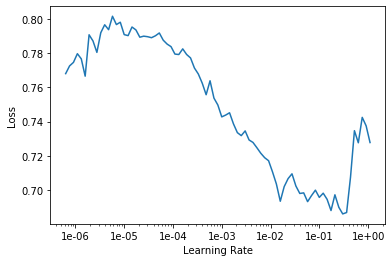

In [131]:
learn_c.recorder.plot()

In [132]:
lr = 4e-3
lr *= bs/48

wd = 0.1

In [133]:
learn_c.fit_one_cycle(2, lr, wd=wd, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,f1,time
0,0.413700,0.280349,0.879004,0.827802,00:20
1,0.415341,0.251620,0.886683,0.846804,00:20


In [134]:
learn_c.save(f'{lang}clas1_sp15_multifit_bwd')

In [135]:
learn_c.load(f'{lang}clas1_sp15_multifit_bwd');
learn_c.freeze_to(-2)
learn_c.fit_one_cycle(2, slice(lr/(2.6**4),lr), wd=wd, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,f1,time
0,0.384325,0.237685,0.895684,0.866170,00:24
1,0.384483,0.257613,0.871062,0.810963,00:25


In [136]:
learn_c.save(f'{lang}clas2_sp15_multifit_bwd')

In [137]:
learn_c.load(f'{lang}clas2_sp15_multifit_bwd');
learn_c.freeze_to(-3)
learn_c.fit_one_cycle(2, slice(lr/2/(2.6**4),lr/2), wd=wd, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,f1,time
0,0.400534,0.225452,0.901244,0.871121,00:28
1,0.366623,0.234236,0.890919,0.851360,00:29


In [138]:
learn_c.save(f'{lang}clas3_sp15_multifit_bwd')

In [139]:
learn_c.load(f'{lang}clas3_sp15_multifit_bwd');
learn_c.unfreeze()
learn_c.fit_one_cycle(1, slice(lr/10/(2.6**4),lr/10), wd=wd, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,f1,time
0,0.399960,0.221284,0.914218,0.898709,00:43


In [140]:
learn_c.load(f'{lang}clas3_sp15_multifit_bwd');
learn_c.unfreeze()
learn_c.fit_one_cycle(1, slice(lr/10/(2.6**4),lr/10), wd=wd, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,f1,time
0,0.345377,0.222420,0.902833,0.877878,00:44


In [141]:
learn_c.load(f'{lang}clas3_sp15_multifit_bwd');
learn_c.unfreeze()
learn_c.fit_one_cycle(1, slice(lr/10/(2.6**4),lr/10), wd=wd, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,f1,time
0,0.351143,0.227948,0.895155,0.866385,00:42


In [142]:
learn_c.save(f'{lang}clas4_sp15_multifit_bwd')

In [143]:
learn_c.load(f'{lang}clas4_sp15_multifit_bwd')
learn_c.save(f'{lang}clas_sp15_multifit_bwd')

In [144]:
learn_c.load(f'{lang}clas_sp15_multifit_bwd');
learn_c.to_fp32().export(f'{lang}_classifier_sp15_multifit_bwd')

### Confusion matrix

In [145]:
%%time
data_clas = load_data(path, f'{lang}_textlist_class_sp15_multifit_bwd', bs=bs, num_workers=1, backwards=True)

config = awd_lstm_clas_config.copy()
config['qrnn'] = True
config['n_hid'] = 1550 #default 1152
config['n_layers'] = 4 #default 3

learn_c = text_classifier_learner(data_clas, AWD_LSTM, config=config, drop_mult=1.0, 
                                  metrics=[accuracy,f1])
learn_c.load_encoder(f'{lang}fine_tuned_enc_sp15_multifit_bwd');

learn_c.load(f'{lang}clas_sp15_multifit_bwd');

# put weight on cpu
loss_weights = torch.FloatTensor(trn_weights).cpu()
learn_c.loss_func = partial(F.cross_entropy, weight=loss_weights)

CPU times: user 2.01 s, sys: 264 ms, total: 2.28 s
Wall time: 1.76 s


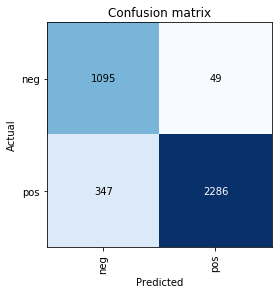

In [146]:
preds,y,losses = learn_c.get_preds(with_loss=True)
predictions = np.argmax(preds, axis = 1)

interp = ClassificationInterpretation(learn_c, preds, y, losses)
interp.plot_confusion_matrix()

In [147]:
preds.shape

torch.Size([3777, 2])

In [148]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(np.array(y), np.array(predictions))
print(cm)

## acc
print(f'accuracy global: {(cm[0,0]+cm[1,1])/(cm[0,0]+cm[0,1]+cm[1,0]+cm[1,1])}')

# acc neg, acc pos
print(f'accuracy on negative reviews: {cm[0,0]/(cm[0,0]+cm[0,1])*100}') 
print(f'accuracy on positive reviews: {cm[1,1]/(cm[1,0]+cm[1,1])*100}')

[[1095   49]
 [ 347 2286]]
accuracy global: 0.8951548848292296
accuracy on negative reviews: 95.71678321678321
accuracy on positive reviews: 86.8211165970376


In [149]:
learn_c.show_results()

text,target,prediction
". ▁providências ▁xxup ▁ate ▁xxup ▁peço ▁xxup , ▁chegou ▁xxup ▁não ▁xxup b y s 39 14 ▁2 ▁xxup y t al ci pe s ▁ ▁xxmaj cta ▁invi ▁xxmaj ▁relógio ▁xxmaj ▁produto ▁xxup ▁o ▁mas ▁xxup , ▁similar ▁xxup ▁produto ▁xxup ▁bem ▁xxup ▁tudo ▁xxup , 1 400 ▁2 ver ▁di ▁xxup ▁pro ▁xxup cta ▁invi ▁xxup ▁pelo ▁xxup ▁trocado ▁xxup ▁veio ▁xxup , 4 5 19 ▁2 -",neg,neg
". ▁esclarecimentos ▁xxup ▁peço ▁xxup . ▁foi ▁xxup ▁que ▁xxup ▁informado ▁xxup ▁sendo ▁xxup ▁está ▁xxup ▁site ▁xxup ▁no ▁xxup ▁porém ▁xxup , ▁entregue ▁xxup ▁foi ▁xxup ▁não ▁xxup ▁produto ▁xxup ▁o ▁que ▁xxup ▁informo ▁xxup p ra t s ▁ ▁xxmaj le b u ▁do ▁xxmaj r l s ▁d ▁xxmaj s ▁camera ▁xxmaj timo gi le ▁ ▁xxmaj ▁couro ▁xxmaj le b u do - ▁x ▁xxmaj ▁dupla",neg,neg
". ▁att ▁xxup , ▁ ▁retorno ▁xxup ▁o aguardo , ▁ ▁xxup ▁frete ▁xxup ▁do ▁xxup ▁valor ▁xxup ▁o ▁devolver ▁xxup ▁deveria ▁xxup ▁vcs ▁xxup pois , ▁ ▁xxup ▁correios ▁xxup ▁do ▁xxup ▁agência ▁xxup ▁na ▁xxup ▁retirar ▁xxup ▁que ▁xxup tive , ▁endereço ▁xxup ▁meu ▁xxup ▁no ▁xxup ▁entregue ▁xxup ▁foi ▁xxup ▁não ▁xxup ▁e ▁frete ▁xxup ▁alto ▁xxup ▁um ▁xxup ▁cobrado ▁xxup ▁foi ▁xxup ▁produto ▁xxup ▁o .",pos,neg
"2 24 09 7 2 99 - 71 ▁ l ▁te ▁xxup ▁contato ▁xxup ▁aguardo ▁xxup ▁chegou ▁xxup ▁nao ▁xxup 20 , ▁17 ▁as ▁xxup 18 - 04 - ▁25 ▁empresa ▁xxup ▁essa ▁xxup ▁com ▁xxup ▁triste ▁xxup ▁mt ▁xxup ▁to ▁xxup ▁produto ▁xxup ▁do ▁xxup r ▁entraga ▁xxup ▁a o ira pr ▁com ▁xxup ▁nao ▁xxup ▁eles ▁xxup ▁entregue ▁xxup ▁ser ▁xxup ▁pra ▁xxup ▁era ▁xxup 18 - 04",neg,neg
"! . ▁resposta ▁xxup ▁nenhuma ▁xxup ▁obtive ▁xxup ▁não ▁xxup ▁agora ▁xxup ▁ate ▁xxup ▁e ▁problema ▁xxup ▁o ▁resolve ▁xxup ▁para ▁xxup ▁emails ▁xxup ▁vários ▁xxup ▁enviei ▁xxup ▁já ▁xxup , ▁entrega ▁xxup ▁de ▁xxup ▁prazo ▁xxup ▁do ▁xxup ▁fora ▁xxup ▁assim ▁xxup ▁mesmo ▁xxup ▁e ), nd u ( ▁1 ▁xxup ▁apenas ▁xxup ▁chegou ▁xxup , ▁produto ▁xxup ▁do ▁xxup ) nd u ▁( ▁xxup ▁2 ▁de ▁xxup ▁pedido",neg,neg


### Predictions some random sentences

In [150]:
import matplotlib.cm as cm

In [151]:
# Get the prediction neg/pos
review = 'Eu não gosto deste produto'
pred = learn_c.predict(review)
print(pred[0], pred[2])

neg tensor([0.9705, 0.0295])


In [152]:
# The darker the word-shading in the below example, the more it contributes to the classification. 
txt_ci = TextClassificationInterpretation.from_learner(learn_c)
test_text = "Eu não gosto deste produto"
txt_ci.show_intrinsic_attention(test_text,cmap=cm.Purples)

In [153]:
txt_ci.intrinsic_attention(test_text)[1]

tensor([0.3375, 0.5761, 1.0000, 0.8423, 0.1770, 0.0294, 0.0044],
       device='cuda:0')

In [154]:
# tabulation showing the first k texts in top_losses along with their prediction, actual,loss, and probability of actual class.
# max_len is the maximum number of tokens displayed. If max_len=None, it will display all tokens.
txt_ci.show_top_losses(5)

Text,Prediction,Actual,Loss,Probability
▁xxbos ▁muito ▁bom ▁gostei ▁do ▁atendimento ▁veio ▁bem ▁antes ▁do ▁prazo,pos,neg,4.11,0.00
▁xxbos ▁xxmaj ▁entrega ▁super ▁rápida ... ▁xxmaj ▁produto ▁com ▁ótima ▁qualidade ... ▁xxmaj ▁super ▁recomendo ...,pos,neg,3.53,0.01
▁xxbos ▁xxmaj ▁ótimo ▁site ▁para ▁comprar ▁muito ▁confiável,pos,neg,3.01,0.01
▁xxbos ▁xxmaj ▁muito ▁bom ▁eu ▁gostei,pos,neg,2.74,0.02
▁xxbos ▁xxmaj ▁tudo ▁bem,pos,neg,2.59,0.02


## Ensemble

In [155]:
bs = 18

In [156]:
config = awd_lstm_clas_config.copy()
config['qrnn'] = True
config['n_hid'] = 1550 #default 1152
config['n_layers'] = 4 #default 3

In [157]:
data_clas = load_data(path, f'{lang}_textlist_class_sp15_multifit', bs=bs, num_workers=1)
learn_c = text_classifier_learner(data_clas, AWD_LSTM, config=config, drop_mult=1.0, metrics=[accuracy,f1]).to_fp16()
learn_c.load(f'{lang}clas_sp15_multifit', purge=False);

In [158]:
preds,targs = learn_c.get_preds(ordered=True)
accuracy(preds,targs),f1(preds,targs)

(tensor(0.9155), tensor(0.9368))

In [159]:
data_clas_bwd = load_data(path, f'{lang}_textlist_class_sp15_multifit_bwd', bs=bs, num_workers=1, backwards=True)
learn_c_bwd = text_classifier_learner(data_clas_bwd, AWD_LSTM, config=config, drop_mult=1.0, metrics=[accuracy,f1]).to_fp16()
learn_c_bwd.load(f'{lang}clas_sp15_multifit_bwd', purge=False);

In [160]:
preds_b,targs_b = learn_c_bwd.get_preds(ordered=True)
accuracy(preds_b,targs_b),f1(preds_b,targs_b)

(tensor(0.8952), tensor(0.9203))

In [161]:
preds_avg = (preds+preds_b)/2

In [162]:
accuracy(preds_avg,targs_b),f1(preds_avg,targs_b)

(tensor(0.9068), tensor(0.9298))

In [163]:
from sklearn.metrics import confusion_matrix

predictions = np.argmax(preds_avg, axis = 1)
cm = confusion_matrix(np.array(targs_b), np.array(predictions))
print(cm)

## acc
print(f'accuracy global: {(cm[0,0]+cm[1,1])/(cm[0,0]+cm[0,1]+cm[1,0]+cm[1,1])}')

# acc neg, acc pos
print(f'accuracy on negative reviews: {cm[0,0]/(cm[0,0]+cm[0,1])*100}') 
print(f'accuracy on positive reviews: {cm[1,1]/(cm[1,0]+cm[1,1])*100}')

[[1095   49]
 [ 303 2330]]
accuracy global: 0.9068043420704263
accuracy on negative reviews: 95.71678321678321
accuracy on positive reviews: 88.49221420432967
